In [5]:
import numpy as np
import scipy.io as sio
import sklearn as sk
import pandas as pd
import pywt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import neighbors
from sklearn.svm import SVC

from sklearn.datasets import make_classification

from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [6]:
hsi_data=sio.loadmat('PaviaU.mat')
PaviaU_data=hsi_data["paviaU"]
dim=PaviaU_data.shape
print(dim)

(610, 340, 103)


In [7]:
hsi_gt=sio.loadmat("PaviaU_gt.mat")
hsi_gt_arr=hsi_gt['paviaU_gt']
y=np.reshape(hsi_gt_arr,(dim[0]*dim[1],1))
print(y.shape)
print(np.unique(y))

(207400, 1)
[0 1 2 3 4 5 6 7 8 9]


In [8]:
twoD_dim=(dim[0]*dim[1],dim[2])
twoD_hsi_data=np.zeros(twoD_dim)
k=0;
for i in range(0,dim[0]):
    for j in range(0,dim[1]):
        twoD_hsi_data[k,:]=PaviaU_data[i,j,:]
        k=k+1
    
print(twoD_hsi_data.shape)

(207400, 103)


In [9]:
twoD_hsi_data_100=twoD_hsi_data[:,0:100]

In [10]:
twoD_dim=twoD_hsi_data_100.shape

In [11]:
twoD_dim

(207400, 100)

In [12]:
db1=pywt.Wavelet('db1')
s=(twoD_dim[0],4*twoD_dim[1])
coefsi=np.zeros(s)
db1=pywt.Wavelet('db1')
for i in range(0,twoD_dim[0]):
    temp=pywt.swt(twoD_hsi_data_100[i,:],db1,level=2,axis=-1)
    coefsi[i,:]=np.ndarray.flatten(np.array(temp))
  
print(np.array(coefsi).shape)

(207400, 400)


In [13]:
s=(610,340,400)
Coefsi_3d_paviaU=np.zeros(s)
for i in range(0,400):
  Coefsi_3d_paviaU[:,:,i]=np.reshape(coefsi[:,i],(610,340))

In [14]:
sio.savemat("Coefsi_3d_paviaU.mat",{"coefsi_3d_paviaU":Coefsi_3d_paviaU})

In [15]:
def loadPaviaUData():

    data = sio.loadmat(os.path.join(
                      'Coefsi_3d_paviaU.mat'))['coefsi_3d_paviaU']
    labels = sio.loadmat(os.path.join(
                        'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [16]:
#  split data to Train and Test Set
def splitTrainTestSet(X, y, classnum=9, testRatio=0.20):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                test_size=testRatio, random_state=345, stratify=y)
    ss=StratifiedShuffleSplit(n_splits=classnum, test_size=testRatio, 
                              train_size=1-testRatio, random_state=0)
    
    for train_index, test_index in ss.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    return X_train, X_test, y_train, y_test

In [17]:
#  over sample 
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), 
                                                   axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

In [18]:
def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

In [19]:
#  apply PCA preprocessing for data sets
def applyPCA(X, numComponents=100):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [20]:
#  pad zeros to dataset
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, 
                     X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + 
         y_offset, :] = X
    return newX

In [21]:
#  create Patches for dataset
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, 
                            windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - 
                                margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [22]:
#  Augment Data
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,100)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, 
                            no,axes=(1, 0), reshape=False, output=None, 
                            order=3, mode='constant', cval=0.0, prefilter=False)
        
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train

In [23]:
def savePreprocessedData(path, X_trainPatches, X_testPatches, y_trainPatches, 
                         y_testPatches, X_all, y_all, windowSize, wasPCAapplied = False, 
                         numPCAComponents = 0, testRatio = 0.20):
    
    

    if wasPCAapplied:
        with open(os.path.join("XtrainWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join( "XtestWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join( "ytrainWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join("ytestWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
        
        with open(os.path.join( "XAllWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_all)
        with open(os.path.join("yAllWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_all)
    else:
        with open(os.path.join("preXtrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join( "preXtestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join( "preytrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join( "preytestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)

In [24]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm, 
# the number of retained features  n
numComponents = 100
# Patches windows size
windowSize = 5
# The proportion of Test sets
testRatio = 0.20

In [25]:
import os
# Load dataset from file and apply PCA
#X, y = loadHSIData()
X,y = loadPaviaUData()
X, pca = applyPCA(X, numComponents=numComponents)

In [26]:
!pip install spectral
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os

from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
from spectral import *

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [27]:
# Preprocess Data
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches,y.max()-y.min(), testRatio) 
                                              # Preprocess Data
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, 
                                                     y.max()-y.min(), testRatio)
X_all = np.append(X_train, X_test, axis=0)
y_all = np.append(y_train, y_test, axis=0)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
# X_all, y_all = oversampleWeakClasses(X_all, y_all)
X_train = AugmentData(X_train)
# X_all = AugmentData(X_all)       y.max()-y.min(), testRatio)
X_all = np.append(X_train, X_test, axis=0)
y_all = np.append(y_train, y_test, axis=0)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
# X_all, y_all = oversampleWeakClasses(X_all, y_all)
X_train = AugmentData(X_train)
# X_all = AugmentData(X_all)

TRAIN: [ 2475 33602  8009 ... 32223  6300 29867] TEST: [24728  2652 35792 ...  4622 21961 29396]
TRAIN: [36369 12882  6050 ... 39972 10721 30970] TEST: [37602  7784 38717 ... 14002  8215 10662]
TRAIN: [22466 31881 18882 ... 22731 35414 41382] TEST: [31511 27080 33684 ... 33476  5349 14252]
TRAIN: [40356 32247  1521 ... 19131  8670 21446] TEST: [32246 13943 24532 ... 34180  4199 16107]
TRAIN: [ 4351  1683 38375 ... 15984 16866 25166] TEST: [23052  7459 36072 ... 15326 24838 29557]
TRAIN: [26657 37260 15698 ...  2228 27529 38144] TEST: [27261 33650 19373 ... 41071  4361 23936]
TRAIN: [41113   945  8880 ... 30640  2288 23600] TEST: [26159 31612 21923 ... 39952  1296  2860]
TRAIN: [13509 12503 41168 ... 41952 21861 32637] TEST: [21903 37226 21085 ... 28017 26957  3374]
TRAIN: [39232 22557 37499 ... 25640  8807  4697] TEST: [ 1698  7910 10687 ... 42628 38116 32493]
TRAIN: [ 2475 33602  8009 ... 32223  6300 29867] TEST: [24728  2652 35792 ...  4622 21961 29396]
TRAIN: [36369 12882  6050 ... 

In [28]:
# save Preprocessed Data to file
savePreprocessedData('predata', X_train, X_test, y_train, y_test, 
                     X_all, y_all, windowSize = windowSize, 
                     wasPCAapplied=True, numPCAComponents = numComponents, 
                     testRatio = testRatio)

In [29]:
# Import the necessary libraries
import numpy as np
import scipy
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.utils import np_utils
from keras.layers import LeakyReLU
#from sklearn.cross_validation import StratifiedKFold

Using TensorFlow backend.


In [30]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm, 
# the number of retained features  n
numPCAcomponents = 100
# Patches windows size
windowSize = 5
# The proportion of Test sets
testRatio = 0.20

In [31]:
# load Preprocessed data from file
X_train = np.load("XtrainWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                  "testRatio" + str(testRatio)  + ".npy")
y_train = np.load("ytrainWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                  "testRatio" + str(testRatio) + ".npy")
X_test = np.load("XtestWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                 "testRatio" + str(testRatio)  + ".npy")
y_test = np.load("ytestWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                 "testRatio" + str(testRatio) + ".npy")

In [32]:
# Reshape data into (numberofsumples, channels, height, width)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[3], 
                               X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[3], 
                             X_test.shape[1], X_test.shape[2]))

# convert class labels to on-hot encoding
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Define the input shape 
input_shape= X_train[0].shape
print(input_shape)

# number of filters
C1 = 3*numPCAcomponents

(100, 5, 5)


In [33]:
# Define the model structure
model = Sequential()

model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(3*C1, (3, 3), activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(6*numPCAcomponents, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

# Define optimization and train method

In [34]:
# Define optimization and train method
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, 
                              min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", verbose=1, 
                              save_best_only=False)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
                              metrics=['accuracy'])

In [35]:
# Start to train model 
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=100, 
                    verbose=1, 
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, checkpointer],
                    shuffle=True)

Train on 136588 samples, validate on 8556 samples
Epoch 1/100
136588/136588 [==============================] - 62s 455us/step - loss: 0.2010 - acc: 0.9328 - val_loss: 0.0576 - val_acc: 0.9795

Epoch 00001: saving model to checkpoint.hdf5
Epoch 2/100
136588/136588 [==============================] - 52s 380us/step - loss: 0.0134 - acc: 0.9972 - val_loss: 0.0555 - val_acc: 0.9820

Epoch 00002: saving model to checkpoint.hdf5
Epoch 3/100
136588/136588 [==============================] - 52s 380us/step - loss: 0.0048 - acc: 0.9992 - val_loss: 0.0585 - val_acc: 0.9832

Epoch 00003: saving model to checkpoint.hdf5
Epoch 4/100
136588/136588 [==============================] - 52s 381us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.0578 - val_acc: 0.9835

Epoch 00004: saving model to checkpoint.hdf5
Epoch 5/100
136588/136588 [==============================] - 52s 382us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0587 - val_acc: 0.9836

Epoch 00005: saving model to checkpoint.hdf5
Epoch 6/10

136588/136588 [==============================] - 52s 381us/step - loss: 7.9207e-05 - acc: 1.0000 - val_loss: 0.0750 - val_acc: 0.9847

Epoch 00043: saving model to checkpoint.hdf5
Epoch 44/100
136588/136588 [==============================] - 52s 380us/step - loss: 8.1701e-05 - acc: 1.0000 - val_loss: 0.0744 - val_acc: 0.9849

Epoch 00044: saving model to checkpoint.hdf5
Epoch 45/100
136588/136588 [==============================] - 52s 382us/step - loss: 8.2507e-05 - acc: 1.0000 - val_loss: 0.0753 - val_acc: 0.9849

Epoch 00045: saving model to checkpoint.hdf5
Epoch 46/100
136588/136588 [==============================] - 52s 381us/step - loss: 7.9984e-05 - acc: 1.0000 - val_loss: 0.0750 - val_acc: 0.9852

Epoch 00046: saving model to checkpoint.hdf5
Epoch 47/100
136588/136588 [==============================] - 53s 386us/step - loss: 7.3502e-05 - acc: 1.0000 - val_loss: 0.0760 - val_acc: 0.9845

Epoch 00047: saving model to checkpoint.hdf5
Epoch 48/100
136588/136588 [====================

136588/136588 [==============================] - 52s 381us/step - loss: 4.3066e-05 - acc: 1.0000 - val_loss: 0.0798 - val_acc: 0.9846

Epoch 00085: saving model to checkpoint.hdf5
Epoch 86/100
136588/136588 [==============================] - 52s 380us/step - loss: 3.4209e-05 - acc: 1.0000 - val_loss: 0.0795 - val_acc: 0.9850

Epoch 00086: saving model to checkpoint.hdf5
Epoch 87/100
136588/136588 [==============================] - 52s 380us/step - loss: 3.5813e-05 - acc: 1.0000 - val_loss: 0.0797 - val_acc: 0.9847

Epoch 00087: saving model to checkpoint.hdf5
Epoch 88/100
136588/136588 [==============================] - 52s 379us/step - loss: 6.2306e-05 - acc: 1.0000 - val_loss: 0.0781 - val_acc: 0.9852

Epoch 00088: saving model to checkpoint.hdf5
Epoch 89/100
136588/136588 [==============================] - 52s 384us/step - loss: 5.8371e-05 - acc: 1.0000 - val_loss: 0.0788 - val_acc: 0.9850

Epoch 00089: saving model to checkpoint.hdf5
Epoch 90/100
136588/136588 [====================

In [36]:
# save the model with h5py
import h5py
from keras.models import load_model
model.save('paviaU_model_epochs100.h5')

In [ ]:
from sklearn.metrics import cross_val_score
from sklearn.cross_validation import KFold
def baseline_model():
        model = Sequential()

        model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
        model.add(Conv2D(3*C1, (3, 3), activation='relu'))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(6*numPCAcomponents, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(9, activation='softmax'))

kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X_train,y_train, cv=kfold)

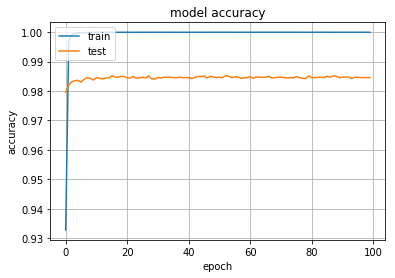

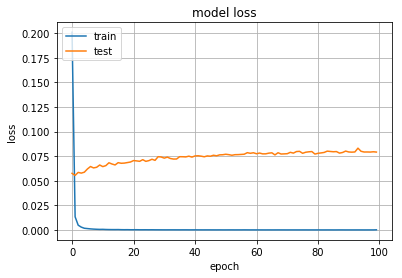

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
plt.savefig("model_accuracy_100_paviou.svg")
plt.show()

# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
plt.savefig("model_loss_100_paviou.svg")
plt.show()

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import scipy.io as sio

In [41]:
# Get the model evaluation report, 
# include classification report, confusion matrix, Test_Loss, Test_accuracy
target_names = ['Water','Trees','Asphalt','Self-Blocking Bricks','Bitumen','Tiles','Shadows','Meadows','Bare Soil']
def reports(X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy

In [43]:
# load the model architecture and weights
model = load_model('paviaU_model_epochs100.h5')

# calculate result, loss, accuray and confusion matrix
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion_str = str(confusion)

# show result and save to file
print('Test loss {} (%)'.format(Test_loss))
print('Test accuracy {} (%)'.format(Test_accuracy))
print("classification result: ")
print('{}'.format(classification))
print("confusion matrix: ")
print('{}'.format(confusion_str))
file_name ="WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('Test loss {} (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('Test accuracy {} (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write(" classification result: \n")
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write(" confusion matrix: \n")
    x_file.write('{}'.format(confusion_str))

8556/8556 [==============================] - 1s 150us/step
Test loss 7.919281568153916 (%)
Test accuracy 98.45722300140253 (%)
classification result: 
                      precision    recall  f1-score   support

               Water       0.99      0.99      0.99      1326
               Trees       1.00      1.00      1.00      3730
             Asphalt       0.94      0.86      0.90       420
Self-Blocking Bricks       1.00      0.99      0.99       613
             Bitumen       1.00      1.00      1.00       269
               Tiles       0.99      1.00      0.99      1006
             Shadows       0.98      1.00      0.99       266
             Meadows       0.91      0.95      0.93       737
           Bare Soil       1.00      1.00      1.00       189

         avg / total       0.98      0.98      0.98      8556

confusion matrix: 
[[1312    0    0    0    0    0    5    9    0]
 [   0 3720    0    1    0    9    0    0    0]
 [   0    1  363    0    0    0    0   56    0]
 

Confusion matrix, without normalization
[[1312    0    0    0    0    0    5    9    0]
 [   0 3720    0    1    0    9    0    0    0]
 [   0    1  363    0    0    0    0   56    0]
 [   0    2    0  607    0    3    0    1    0]
 [   0    0    0    0  269    0    0    0    0]
 [   0    5    0    0    0 1001    0    0    0]
 [   0    0    0    0    0    0  265    1    0]
 [  15    0   23    0    0    0    1  698    0]
 [   0    0    0    0    0    0    0    0  189]]


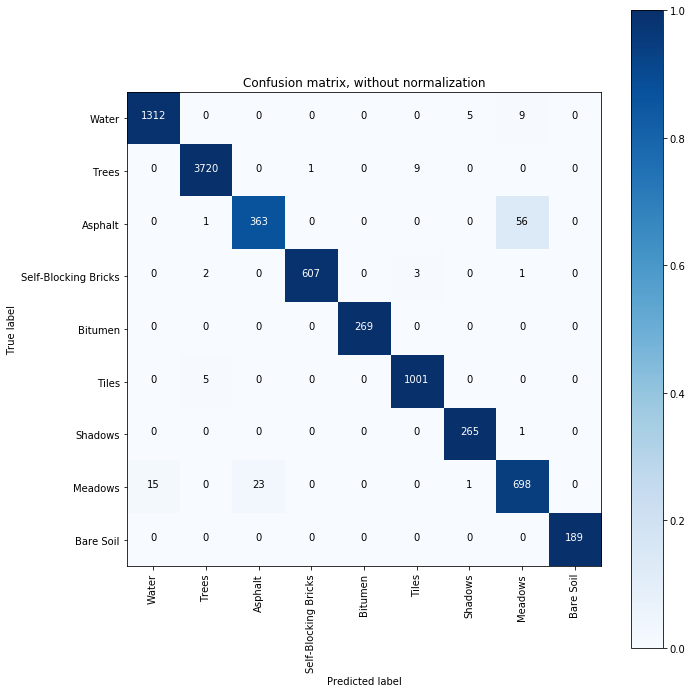

Normalized confusion matrix
[[9.89441931e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.77073906e-03 6.78733032e-03
  0.00000000e+00]
 [0.00000000e+00 9.97319035e-01 0.00000000e+00 2.68096515e-04
  0.00000000e+00 2.41286863e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.38095238e-03 8.64285714e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.33333333e-01
  0.00000000e+00]
 [0.00000000e+00 3.26264274e-03 0.00000000e+00 9.90212072e-01
  0.00000000e+00 4.89396411e-03 0.00000000e+00 1.63132137e-03
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.97017893e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.95029821e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.96240602e-01 3.75939850e

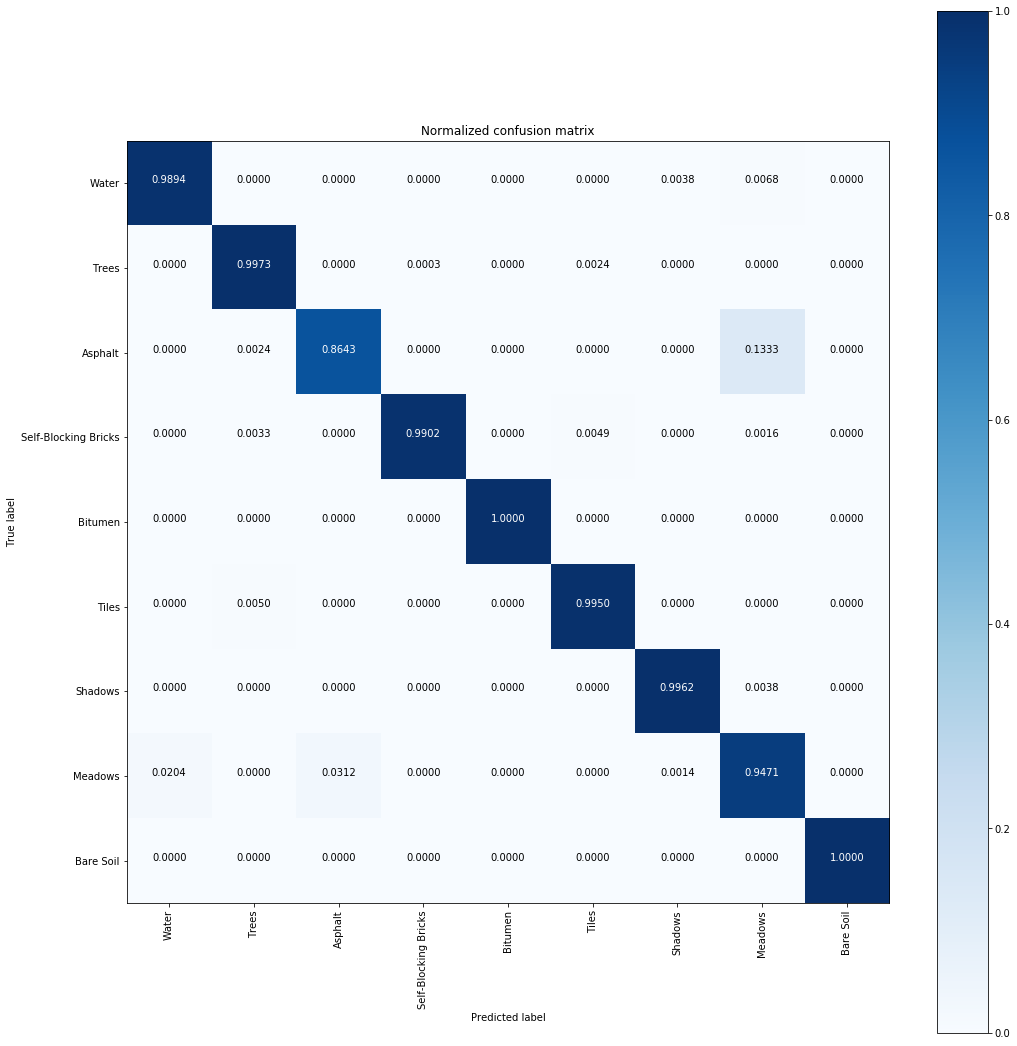

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.get_cmap("Blues")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if normalize:
        cm = Normalized
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(Normalized, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        thresh = cm[i].max() / 2.
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion, classes=target_names, normalize=False, 
                      title='Confusion matrix, without normalization')
plt.savefig("confusion_matrix_without_normalization.svg")
plt.show()
plt.figure(figsize=(15,15))
plot_confusion_matrix(confusion, classes=target_names, normalize=True, 
                      title='Normalized confusion matrix')
plt.savefig("confusion_matrix_with_normalization.svg")
plt.show()

In [46]:
# load the original image
X, y = loadPaviaUData()
X, pca = applyPCA(X, numComponents=numPCAcomponents)

In [47]:
def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 5
numComponents = 30

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        p = int(PATCH_SIZE/2)
        # print(y[i+p][j+p])
        # target = int(y[i+PATCH_SIZE/2, j+PATCH_SIZE/2])
        target = y[i+p][j+p]
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            # print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[i+p][j+p] = prediction+1

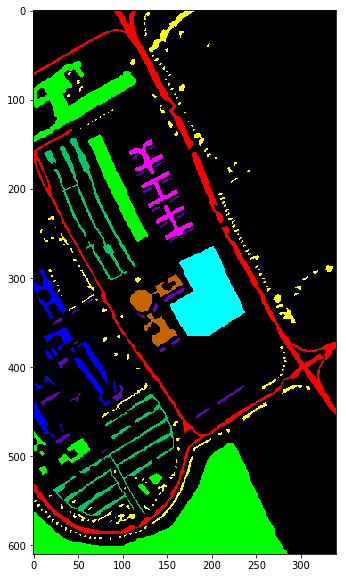

In [48]:
ground_truth = imshow(classes=y, figsize=(10, 10))

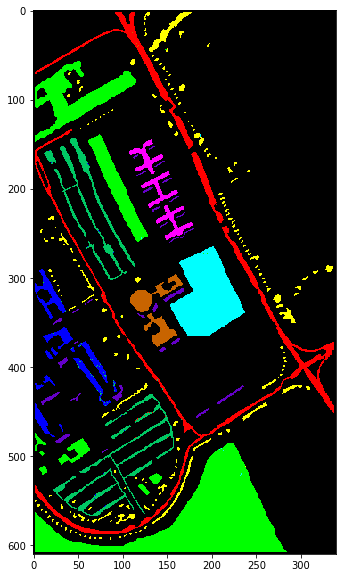

In [49]:
predict_image = imshow(classes=outputs.astype(int), figsize=(10, 10))